# Examples of retreiving information from Butler and Headers of all Images in an EO run

In [6]:
import numpy as np
import pandas as pd
import scipy as sp
import time
from tabulate import tabulate

import lsst.daf.butler as daf_butler
import lsst.afw.math as afw_math
from matplotlib import pyplot as plt
from astropy.stats import sigma_clip
from astropy.io import fits
from scipy.stats import skew
import logging

import lsst.afw.display as afwDisplay
from astropy.visualization import imshow_norm, MinMaxInterval,AsinhStretch,LinearStretch,SqrtStretch,ZScaleInterval,AsymmetricPercentileInterval,ManualInterval
import sys
sys.path.append('/home/s/seanmacb/Camera/pkgs')

from myutils_ar.myutils import *

In [7]:
repo = '/repo/main'
collections = ['LSSTCam/raw/all']
butler_raw = daf_butler.Butler(repo, collections=collections)

In [10]:
runnum = '12606'
dsrefs = get_dsrefs(runnum,butler_raw,detector=1)
print(len(dsrefs))
df = get_run_info(runnum,butler_raw,detector=1)

230


In [11]:
print(tabulate(df,headers = 'keys', tablefmt = 'psql',floatfmt='0.3f'))

+-----+-------------------+---------------+----------------------+-----------------+-------------+--------------------+----------------------+-----------+-----------+-------------+-----------+------------+
|     | physical_filter   |            id | obs_id               |   exposure_time |   dark_time | observation_type   | observation_reason   |   day_obs |   seq_num |   mjd_begin |   mjd_end |   detector |
|-----+-------------------+---------------+----------------------+-----------------+-------------+--------------------+----------------------+-----------+-----------+-------------+-----------+------------|
| 109 | unknown           | 3020100800018 | MC_C_20201008_000018 |           0.000 |       0.021 | bias               | bias                 |  20201008 |        18 |   59131.032 | 59131.032 |          1 |
|  34 | unknown           | 3020100800019 | MC_C_20201008_000019 |           0.000 |       0.023 | bias               | bias                 |  20201008 |        19 |   59131.0

In [9]:
df['mjd_delta_sec'] =  24.*3600.*(df.mjd_end-df.mjd_begin)

In [10]:
# now from the header...
detector =112  #R24_S11
dsrefs = get_dsrefs(runnum,butler_raw,detector=detector)

In [21]:
# get metadata from a set of images
def get_metadata(butler,dsrefs,keys):
    sttime = time.time()

    dfdictm = {}
    for akey in keys:
        dfdictm[akey] = []

    print("Number of images: ",len(dsrefs))
    for i,aref in enumerate(dsrefs):
        rawmeta = butler.get(aref.makeComponentRef("metadata"))
        for akey in keys:
            dfdictm[akey].append(rawmeta[akey])
        
    edtime = time.time()

    print('Total time: ',edtime-sttime)

    dfmeta = pd.DataFrame(dfdictm)
    dfmetas = dfmeta.sort_values(by=['SEQNUM'],ignore_index=True)
    return dfmetas


In [22]:
keys = ['OBSID','DAYOBS','SEQNUM','MJD-OBS','MJD-TRG','EXPTIME','DARKTIME','IMGTYPE','TESTTYPE','TEMP6','TEMP10','CCDTEMP','BSSVBS']
dfmeta = get_metadata(butler_raw,dsrefs,keys)


Number of images:  230
Total time:  1.145148515701294


In [24]:
print(tabulate(dfmeta[['OBSID','EXPTIME','DARKTIME','IMGTYPE','TESTTYPE','TEMP6','CCDTEMP','BSSVBS']],headers = 'keys', tablefmt = 'psql',floatfmt='0.3f'))

+-----+----------------------+-----------+------------+-----------+-----------------+---------+-----------+----------+
|     | OBSID                |   EXPTIME |   DARKTIME | IMGTYPE   | TESTTYPE        |   TEMP6 |   CCDTEMP |   BSSVBS |
|-----+----------------------+-----------+------------+-----------+-----------------+---------+-----------+----------|
|   0 | MC_C_20201009_000001 |     0.000 |      0.019 | BIAS      | BOT_PERSISTENCE |  -3.812 |  -101.984 |   47.350 |
|   1 | MC_C_20201009_000002 |     0.000 |      0.019 | BIAS      | BOT_PERSISTENCE |  -3.812 |  -101.380 |   47.350 |
|   2 | MC_C_20201009_000003 |     0.000 |      0.019 | BIAS      | BOT_PERSISTENCE |  -3.812 |  -102.264 |   47.350 |
|   3 | MC_C_20201009_000004 |     0.000 |      0.019 | BIAS      | BOT_PERSISTENCE |  -3.812 |  -101.848 |   47.350 |
|   4 | MC_C_20201009_000005 |     0.000 |      0.015 | BIAS      | BOT_PERSISTENCE |  -3.812 |  -101.744 |   47.350 |
|   5 | MC_C_20201009_000006 |     0.000 |      

In [25]:
# merge and write out
dfmerge = df.merge(dfmeta,how='outer',left_on='obs_id',right_on='OBSID',suffixes=('','_META'))
print(dfmerge.columns)
print(len(dfmerge))
dfmerge.to_parquet('run%s_info.parquet' % (runnum))

Index(['physical_filter', 'id', 'obs_id', 'exposure_time', 'dark_time',
       'observation_type', 'observation_reason', 'day_obs', 'seq_num',
       'mjd_begin', 'mjd_end', 'detector', 'mjd_delta_sec', 'OBSID', 'DAYOBS',
       'SEQNUM', 'MJD-OBS', 'MJD-TRG', 'EXPTIME', 'DARKTIME', 'IMGTYPE',
       'TESTTYPE', 'TEMP6', 'TEMP10', 'CCDTEMP', 'BSSVBS'],
      dtype='object')
230


Text(0.5, 1.0, 'Run 12606 Flat Images')

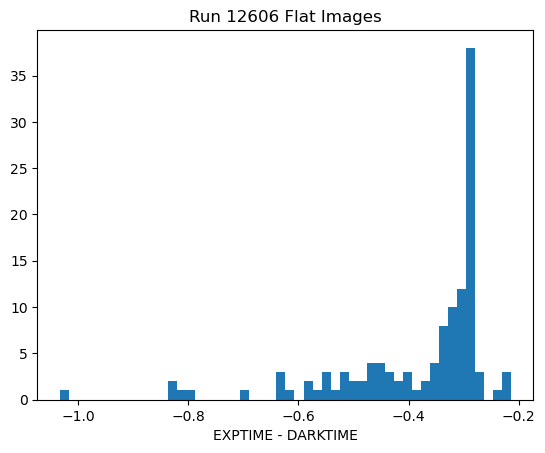

In [26]:
# DarkTime - ExpTime
f,ax = plt.subplots(1,1)
flats = (dfmeta['IMGTYPE'] == 'FLAT')
h = ax.hist(dfmeta[flats]['EXPTIME']-dfmeta[flats]['DARKTIME'],bins=50)
ax.set_xlabel('EXPTIME - DARKTIME')
ax.set_title('Run %s Flat Images'%(runnum))

Text(0.5, 0, 'Sequence Number')

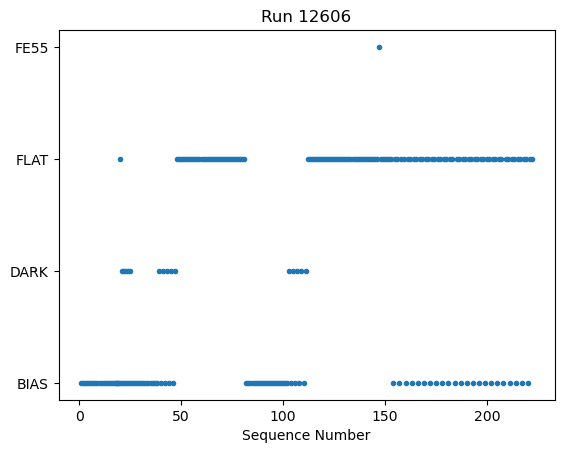

In [29]:
f,ax = plt.subplots(1,1)
h = ax.scatter(dfmerge.seq_num,dfmerge.IMGTYPE,marker='.')
ax.set_title('Run %s' % (runnum))
ax.set_xlabel('Sequence Number')